# Simple GP Regression 

Gaussian processes are a powerful tool for nonlinear regression models. 

Assume that we have **predictor** variables $\mathbf{X} = \{\mathbf{x_i}\}_{i=1}^N \in \mathbb{R}^d$ and **response** variables $\mathbf{y}=\{y_i \in \mathbb{R}\}_{i=1}^N$.

The response variables $\mathbf{y}$ are assumed to dependent on the predictors $\mathbf{X}$,

\begin{equation}
y_i \sim \mathcal{N}(f(\mathbf{x}_i),\sigma^2), \ i=1,\ldots,n,  
\end{equation}

where $f$ is a mapping function. Treating $f$ as a random function, we assume that the distribution over $f$ is a **Gaussian process**,
$$
f \sim \mathcal{GP}(m(\mathbf{x}),k(\mathbf{x},\mathbf{x}')),
$$
where $m(\cdot)$ and $k(\cdot,\cdot)$ are the mean and kernel functions respectively.

## 1D regression example

We start by simulating some data

In [14]:
using GaussianProcesses

srand(13579)
# Training data
n=10;                          #number of training points
x = 2π * rand(n);              #predictors
y = sin.(x) + 0.05*randn(n);    #regressors

The first step in modelling with Gaussian Processes is to choose mean functions and kernels which describe the process. GaussianProcesses can be optionally used with a plotting package. Currently the packages [Gadfly](https://github.com/dcjones/Gadfly.jl) and [PyPlot](https://github.com/stevengj/PyPlot.jl) are supported.

**Note** that all hyperparameters for the **mean** and **kernel** functions and $\sigma$ are given on the log scale. This is true for all strictly positive hyperparameters. Gaussian Processes are represented by objects of type 'GP' and constructed from observation data, a mean function and kernel, and optionally the amount of observation noise.

In [15]:
#Select mean and covariance function
mZero = MeanZero()                   #Zero mean function
kern = SE(0.0,0.0)                   #Sqaured exponential kernel (note that hyperparameters are on the log scale)

logObsNoise = -1.0                        # log standard deviation of observation noise (this is optional)
gp = GP(x,y,mZero,kern,logObsNoise)       #Fit the GP

GP Exact object:
  Dim = 1
  Number of observations = 10
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Any[]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [0.0, 0.0]
  Input observations = 
[5.66072 1.67222 … 6.08978 3.39451]
  Output observations = [-0.505287, 1.02312, 0.616955, -0.777658, -0.875402, 0.92976, -1.04525, -0.00543704, -0.301759, -0.364661]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -6.719

Once we've fit the `GP` function to the data, we can calculate the **predicted mean** and **variance** of of the function at unobserved points $\{\mathbf{x}^*,y^*\}$, conditional on the observed data $\mathcal{D}=\{\mathbf{y},\mathbf{X}\}$. This is done with the `predict_y` function.

The `predict_y` function returns the mean vector $\mu(\mathbf{x}^*)$ and covariance matrix (variance vector if `full_cov=false`) $\Sigma(\mathbf{x}^*,\mathbf{x}^{*^\top})$ of the predictive distribution,
\begin{equation}
    y^*|\mathbf{x^*},\mathcal{D} \sim \mathcal{N}(\mu(\mathbf{x}^*),\Sigma(\mathbf{x}^*,\mathbf{x}^{*^\top})+\sigma^2\mathbf{I}),
\end{equation}
where 
\begin{align}
\mu(\mathbf{x}^*) &= k(\mathbf{x}^*,\mathbf{X})(k(\mathbf{X}, \mathbf{X}) + \sigma_n^2 \mathbf{I})^{-1}\mathbf{y} \\ \Sigma(\mathbf{x}^*,\mathbf{x}^{*'}) &= k(\mathbf{x}^*,\mathbf{x}^*) -k(\mathbf{x}^*,\mathbf{X})(k(\mathbf{X}, \mathbf{X})+ \sigma_n^2 \mathbf{I})^{-1} k(\mathbf{X},\mathbf{x}^*).
\end{align}

**Note** you can use the `predict_f` function to predict the latent function $\mathbf{f}^*$.

In [16]:
μ, σ² = predict_y(gp,linspace(0,2π,100));

Plotting GPs is straightforward and utilises the recipes approach to plotting from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package. More information about plotting GPs and the available functionality can be found in this [notebook](https://github.com/STOR-i/GaussianProcesses.jl/blob/master/notebooks/Plotting%20GPs.ipynb).

The default plot function `plot(gp)` outputs the predicted mean and variance of the function (i.e. uses `predict_f` in the background), with the uncertainty in the function represented by a confidence ribbon (set to 95% by default). All optional plotting arguments are given after `;`.


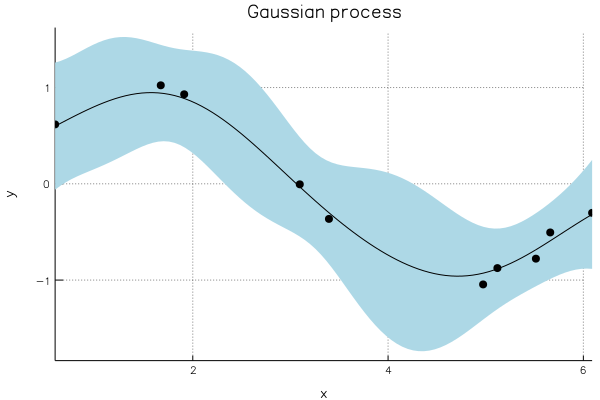

In [17]:
using Plots  #Load Plots.jl package

plot(gp; xlabel="x", ylabel="y", title="Gaussian process", legend=false, fmt=:png)      #Plot the GP

The hyperparameters are optimized using the [Optim.jl](https://github.com/JuliaOpt/Optim.jl) package. This offers users a range of optimization algorithms which can be applied to estimate the hyperparameters using type II maximum likelihood estimation. Gradients are available for all mean and kernel functions used in the package and therefore it is recommended that the user utilizes gradient based optimization techniques. As a default, the `optimize!` function uses the `L-BFGS` solver, however, alternative solvers can be applied. 

In [18]:
optimize!(gp; method=Optim.BFGS())   #Optimise the hyperparameters

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [-1.0,0.0,0.0]
 * Minimizer: [-2.6830552359721374,0.43421518130435494, ...]
 * Minimum: -4.902989e-01
 * Iterations: 9
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 34
 * Gradient Calls: 34

In [19]:
plot(gp)   #Plot the GP after the hyperparameters have been optimised 

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2 
 
 
 4 
 
 
 6 
 
 
 -1 
 
 
 0 
 
 
 1 
 
<polygon clip-path="url(#clip02)" points="
39.3701,109.608 44.9535,103.914 50.5369,98.7029 56.1203,93.8998 61.7037,89.4245 67.287,85.206 72.8704,81.1912 78.4538,77.346 84.0372,73.6541 89.6206,70.1138 
 95.204,66.7359 100.787,63.5403 106.371,60.555 111.954,57.814 117.538,55.3568 123.121,53.2268 128.704,51.4715 134.288,50.1407 139.871,49.2851 145.455,48.9545 
 151.038,49.1937 156.621,50.0388 162.205,51.5129 167.788,53.6232 173.372,56.3603 178.955,59.701 184.538,63.6116 190.122,68.0529 195.705,72.9831 201.288,78.3611 
 206.872,84.1471 212.455,90.3036 218.039,96.7959 223.622,103.591 229.205,110.661 234.789,117.976 240.372,125.512 245.956,133.247 251.539,141.161 257.122,149.237 
 262.706,157.462 268.289,165.826 273.873,174.323 279.456,182.952 285.039,191.714 290.623,200.613 296.206,209.652 301.79,218.829 307.373,228.132 312.956,237.538 
 318.54,247.007 324.123,256.486 329.707,265.911 335.29,275.215 340.873,284.33 346.457,293.19 352.04,301.732 357.623,309.901 363.207,317.643 368.79,324.914 
 374.374,331.673 379.957,337.884 385.54,343.518 391.124,348.551 396.707,352.963 402.291,356.739 407.874,359.871 413.457,362.354 419.041,364.191 424.624,365.385 
 430.208,365.949 435.791,365.897 441.374,365.25 446.958,364.032 452.541,362.273 458.125,360.005 463.708,357.267 469.291,354.098 474.875,350.542 480.458,346.646 
 486.042,342.454 491.625,338.012 497.208,333.359 502.792,328.53 508.375,323.549 513.958,318.434 519.542,313.196 525.125,307.842 530.709,302.381 536.292,296.826 
 541.875,291.199 547.459,285.531 553.042,279.863 558.626,274.25 564.209,268.755 569.792,263.45 575.376,258.405 580.959,253.686 586.543,249.35 592.126,245.439 
 592.126,209.76 586.543,217.004 580.959,224.056 575.376,230.916 569.792,237.596 564.209,244.115 558.626,250.497 553.042,256.759 547.459,262.914 541.875,268.96 
 536.292,274.884 530.709,280.659 525.125,286.251 519.542,291.614 513.958,296.699 508.375,301.457 502.792,305.843 497.208,309.817 491.625,313.352 486.042,316.429 
 480.458,319.04 474.875,321.18 469.291,322.852 463.708,324.059 458.125,324.809 452.541,325.107 446.958,324.962 441.374,324.38 435.791,323.369 430.208,321.937 
 424.624,320.093 419.041,317.845 413.457,315.201 407.874,312.171 402.291,308.763 396.707,304.986 391.124,300.85 385.54,296.362 379.957,291.531 374.374,286.366 
 368.79,280.872 363.207,275.058 357.623,268.926 352.04,262.482 346.457,255.725 340.873,248.656 335.29,241.273 329.707,233.57 324.123,225.544 318.54,217.195 
 312.956,208.527 307.373,199.556 301.79,190.314 296.206,180.848 290.623,171.216 285.039,161.489 279.456,151.741 273.873,142.043 268.289,132.468 262.706,123.079 
 257.122,113.935 251.539,105.09 245.956,96.5899 240.372,88.4753 234.789,80.7806 229.205,73.534 223.622,66.7575 218.039,60.467 212.455,54.6718 206.872,49.3748 
 201.288,44.5719 195.705,40.2521 190.122,36.3977 184.538,32.985 178.955,29.9851 173.372,27.3671 167.788,25.1014 162.205,23.1639 156.621,21.5405 151.038,20.229 
 145.455,19.239 139.871,18.5893 134.288,18.3034 128.704,18.406 123.121,18.9196 117.538,19.8624 111.954,21.2471 106.371,23.0801 100.787,25.361 95.204,28.0818 
 89.6206,31.2268 84.0372,34.7704 78.4538,38.6765 72.8704,42.8959 67.287,47.3636 61.7037,51.9966 56.1203,56.6926 50.5369,61.3319 44.9535,65.7858 39.3701,69.9307 
 
 " fill="#add8e6" fill-opacity="1"/>
<polyline clip-path="url(#clip02)" style="stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.3701,89.7693 44.9535,84.8497 50.5369,80.0174 56.1203,75.2962 61.7037,70.7105 67.287,66.2848 72.8704,62.0435 78.4538,58.0113 84.0372,54.2122 89.6206,50.6703 
 95.204,47.4088 100.787,44.4506 106.371,41.8175 111.954,39.5306 117.538,37.6096 123.121,36.0732 128.704,34.9388 134.288,34.222 139.871,33.9372 145.455,34.0968 
 151.038,34.7113 156.621,35.7896 162.205,37.3384 167.788,39.3623 173.372,41.8637 178.955,44.843 184.538,48.2983 190.122,52.2253 195.705,5

## Multi-dimensional regression

The regression example above can be easily extended to higher dimensions. For the purpose of visualisation, and without loss of generality, we consider a 2 dimensional regression example.

In [20]:
#Training data
d, n = 2, 50;         #Dimension and number of observations
x = 2π * rand(d, n);                               #Predictors
y = vec(sin.(x[1,:]).*sin.(x[2,:])) + 0.05*rand(n);  #Responses

For problems of dimension>1 we can use isotropic (`Iso`) kernels or automatic relevance determination (`ARD`) kernels. For `Iso` kernels, the length scale parameter $\ell$ is the same for all dimensions. For `ARD` kernels, each dimension has different length scale parameter.

The `Iso` and `ARD` kernels are implemented automatically by replacing the single length scale parameter with a vector of parameters. For example, below we use the Matern 5/2 `ARD` kernel, if we wanted to use the `Iso` alternative then we would set the kernel as `kern=Mat(5/2,0.0,0.0)`.

In this example we use a composite kernel represented as the sum of a Matern 5/2 ARD kernel and a Squared Exponential isotropic kernel. This is easily implemented using the `+` symbol, or in the case of a product kernel, using the `*` symbol (i.e. `kern = Mat(5/2,[0.0,0.0],0.0) * SE(0.0,0.0)`).

In [21]:
mZero = MeanZero()                             # Zero mean function
kern = Matern(5/2,[0.0,0.0],0.0) + SE(0.0,0.0)    # Sum kernel with Matern 5/2 ARD kernel 
                                               # with parameters [log(ℓ₁), log(ℓ₂)] = [0,0] and log(σ) = 0
                                               # and Squared Exponential Iso kernel with
                                               # parameters log(ℓ) = 0 and log(σ) = 0

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.Mat52Ard, Params: [-0.0, -0.0, 0.0]
  Type: GaussianProcesses.SEIso, Params: [0.0, 0.0]


Fit the Gaussian process to the data using the prespecfied mean and covariance functions.

In [22]:
gp = GP(x,y,mZero,kern,-2.0)          # Fit the GP

GP Exact object:
  Dim = 2
  Number of observations = 50
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Any[]
  Kernel:
    Type: GaussianProcesses.SumKernel
      Type: GaussianProcesses.Mat52Ard, Params: [-0.0, -0.0, 0.0]
      Type: GaussianProcesses.SEIso, Params: [0.0, 0.0]
  Input observations = 
[1.43935 0.515919 … 0.487943 2.38029; 4.21509 3.59947 … 0.699132 4.09243]
  Output observations = [-0.850956, -0.173897, 0.555086, -0.579203, -0.116111, -0.304235, -0.192372, -0.55408, 0.649668, -0.226597  …  -0.874219, -0.136116, 0.485536, 0.571545, -0.387655, 0.200481, -0.33697, 0.395318, 0.340145, -0.545092]
  Variance of observation noise = 0.01831563888873418
  Marginal Log-Likelihood = -24.337

Using the [Optim](https://github.com/JuliaOpt/Optim.jl) package we have the option to choose from a range of optimize functions including conjugate gradients. It is also possible to fix the hyperparameters in either the mean function, kernel function or observation noise, by settting them to false in `optimize!` (e.g. `optimize!(...,mean=false)`).

In [23]:
optimize!(gp)                         # Optimize the hyperparameters

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-2.0,-0.0,-0.0,0.0,0.0,0.0]
 * Minimizer: [-4.433048233786778,-0.5062447634178322, ...]
 * Minimum: -5.401611e+01
 * Iterations: 31
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * f(x) > f(x'): false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 131
 * Gradient Calls: 131

A range of plotting options are availbe through the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

In [24]:
plot(contour(gp) ,heatmap(gp))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 4 
 
 
 5 
 
 
 2 
 
 
 4 
 
 
 6 
 
 
<polyline clip-path="url(#clip02)" style="stroke:#d24742; stroke-width:1; stroke-opacity:1; fill:none" points="
 67.5114,376.378 66.9066,376.112 62.9728,373.968 59.039,371.106 56.6491,368.857 55.1053,367.183 51.1715,361.59 51.0268,361.337 47.5977,353.816 47.2377,352.771 
 45.3616,346.296 43.8774,338.776 43.3039,334.563 42.8987,331.255 42.2469,323.735 41.8045,316.214 41.5113,308.694 41.3463,301.173 41.2982,293.653 41.3492,286.132 
 41.4899,278.612 41.7278,271.091 42.0628,263.571 42.4993,256.05 43.0607,248.53 43.3039,245.882 43.8034,241.009 44.8239,233.489 46.305,225.968 47.2377,222.556 
 48.6765,218.448 51.1715,213.541 53.0604,210.927 55.1053,208.78 59.039,205.879 62.9728,203.933 64.3872,203.407 66.9066,202.592 70.8404,201.64 74.7742,200.957 
 78.708,200.482 82.6418,200.179 86.5756,200.032 90.5094,200.034 94.4432,200.192 98.377,200.521 102.311,201.048 106.245,201.818 110.178,202.899 111.59,203.407 
 114.112,204.427 118.046,206.601 121.98,209.768 123.063,210.927 125.914,214.794 127.848,218.448 129.847,223.637 130.551,225.968 132.272,233.489 133.489,241.009 
 133.781,243.274 134.381,248.53 135.068,256.05 135.616,263.571 136.061,271.091 136.423,278.612 136.712,286.132 136.929,293.653 137.068,301.173 137.122,308.694 
 137.078,316.214 136.909,323.735 136.57,331.255 135.994,338.776 135.079,346.296 133.781,353.182 133.636,353.816 131.256,361.337 129.847,364.414 127.091,368.857 
 125.914,370.332 121.98,374.017 118.306,376.378 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#ba3655; stroke-width:1; stroke-opacity:1; fill:none" points="
 140.935,376.378 141.649,372.778 142.2,368.857 142.735,361.337 142.94,353.816 142.974,346.296 142.91,338.776 142.781,331.255 142.603,323.735 142.395,316.214 
 142.171,308.694 141.941,301.173 141.707,293.653 141.649,291.843 141.467,286.132 141.226,278.612 140.985,271.091 140.743,263.571 140.497,256.05 140.24,248.53 
 139.96,241.009 139.633,233.489 139.214,225.968 138.617,218.448 137.715,211.397 137.635,210.927 135.637,203.407 133.781,199.924 129.847,196.199 129.323,195.886 
 125.914,194.357 121.98,193.255 118.046,192.524 114.112,192.01 110.178,191.637 106.245,191.362 102.311,191.161 98.377,191.017 94.4432,190.917 90.5094,190.85 
 86.5756,190.807 82.6418,190.78 78.708,190.758 74.7742,190.736 70.8404,190.703 66.9066,190.652 62.9728,190.573 59.039,190.451 55.1053,190.263 51.1715,189.966 
 47.2377,189.454 43.3039,188.377 43.277,188.366 39.3701,184.532 
 "/>
 
<polyline clip-path="url(#clip02)" style="stroke:#9e2a62; stroke-width:1; stroke-opacity:1; fill:none" points="
 51.7901,7.87402 51.1715,9.16118 48.7427,15.3945 47.2377,20.0827 46.4697,22.915 44.7601,30.4355 43.4391,37.956 43.3039,38.8881 42.4394,45.4765 41.6842,52.9969 
 41.1297,60.5174 40.745,68.0379 40.5059,75.5584 40.3941,83.0789 40.3977,90.5994 40.5098,98.1199 40.7288,105.64 41.0579,113.161 41.5039,120.681 42.0796,128.202 
 42.8242,135.722 43.3039,139.569 43.8158,143.243 45.1796,150.763 47.1557,158.284 47.2377,158.533 50.3349,165.804 51.1715,167.237 55.1053,172.166 56.4001,173.325 
 59.039,175.273 62.9728,177.356 66.9066,178.814 70.8404,179.851 74.7742,180.589 76.6891,180.845 78.708,181.1 82.6418,181.436 86.5756,181.632 90.5094,181.711 
 94.4432,181.685 98.377,181.559 102.311,181.329 106.245,180.976 107.308,180.845 110.178,180.464 114.112,179.731 118.046,178.674 121.98,177.108 125.914,174.661 
 127.403,173.325 129.847,170.444 132.361,165.804 133.781,161.84 134.717,158.284 136.03,150.763 136.833,143.243 137.362,135.722 137.715,128.589 137.732,128.202 
 137.98,120.681 138.124,113.161 138.174,105.64 138.15,98.1199 138.07,90.5994 137.945,83.0789 137.782,75.5584 137.715,72.888 137.584,68.0379 137.361,60.5174 
 137.126,52.9969 136.898,45.4765 136.71,37.956 136.615,30.4355 136.695,22.915 137.099,15.3945 137.715,10.4825 138.126,7.87402 
 "/>
<polyline clip-path="url(#clip02)" s